# Distance Model

## Imports

In [1]:
import matplotlib
import seaborn as sns
import sys
import os
import pandas as pd
sys.setrecursionlimit(5000)
sns.set_context('notebook')
%load_ext autoreload
%autoreload 2
%matplotlib inline
matplotlib.rcParams['savefig.dpi'] = 200
from matplotlib import pyplot as plt

import numpy as np
from scipy import optimize
from sklearn import model_selection, metrics

In [2]:
os.chdir('/gpfs/data01/glasslab/home/jtao/analysis/distance_analysis/')

## Generate Synthetic Data

### Data with Distance Relationship

In [3]:
optimal_distances = 7
optimal_score = 7
total_samples = 1000

# generate positive samples with good score and good distances
pos_distances = np.random.normal(
    loc = optimal_distances, # mean
    scale=0.75, # standard devication
    size=int(total_samples/2) # num samples
)
neg_distances = np.random.normal(
    loc = 10 - optimal_distances, # mean
    scale=2, # standard devication
    size=int(total_samples/2) # num samples
)
pos_scores = np.random.normal(
    loc = optimal_score, # mean
    scale=0.75, # standard devication
    size=int(total_samples/2) # num samples
)
neg_scores = np.random.normal(
    loc = 10 - optimal_score, # mean
    scale=2, # standard devication
    size=int(total_samples/2) # num samples
)

scores = list(pos_scores) + list(neg_scores)
distances = list(pos_distances) + list(neg_distances)

# min max scores and distances
scores = np.array([max(0,x) for x in scores])
distances = np.array([max(0,x) for x in distances])
labels = [1 for x in range(int(total_samples/2))] + [0 for x in range(int(total_samples/2))]

distance_data = (scores[:], distances[:], labels)

### Data without Distance Relationship

In [4]:
optimal_distances = 7
optimal_score = 7
total_samples = 1000

# generate positive samples with good score and good distances
distances = np.random.normal(
    loc = 5,
    scale=3, # standard devication
    size=total_samples # num samples
)
pos_scores = np.random.normal(
    loc = optimal_score, # mean
    scale=0.75, # standard devication
    size=int(total_samples/2) # num samples
)
neg_scores = np.random.normal(
    loc = 10 - optimal_score, # mean
    scale=2, # standard devication
    size=int(total_samples/2) # num samples
)

scores = list(pos_scores) + list(neg_scores)

# min max scores and distances
scores = np.array([max(0,x) for x in scores])
distances = np.array([max(0,x) for x in distances])
labels = [1 for x in range(int(total_samples/2))] + [0 for x in range(int(total_samples/2))]

nodistance_data = (scores[:], distances[:], labels)

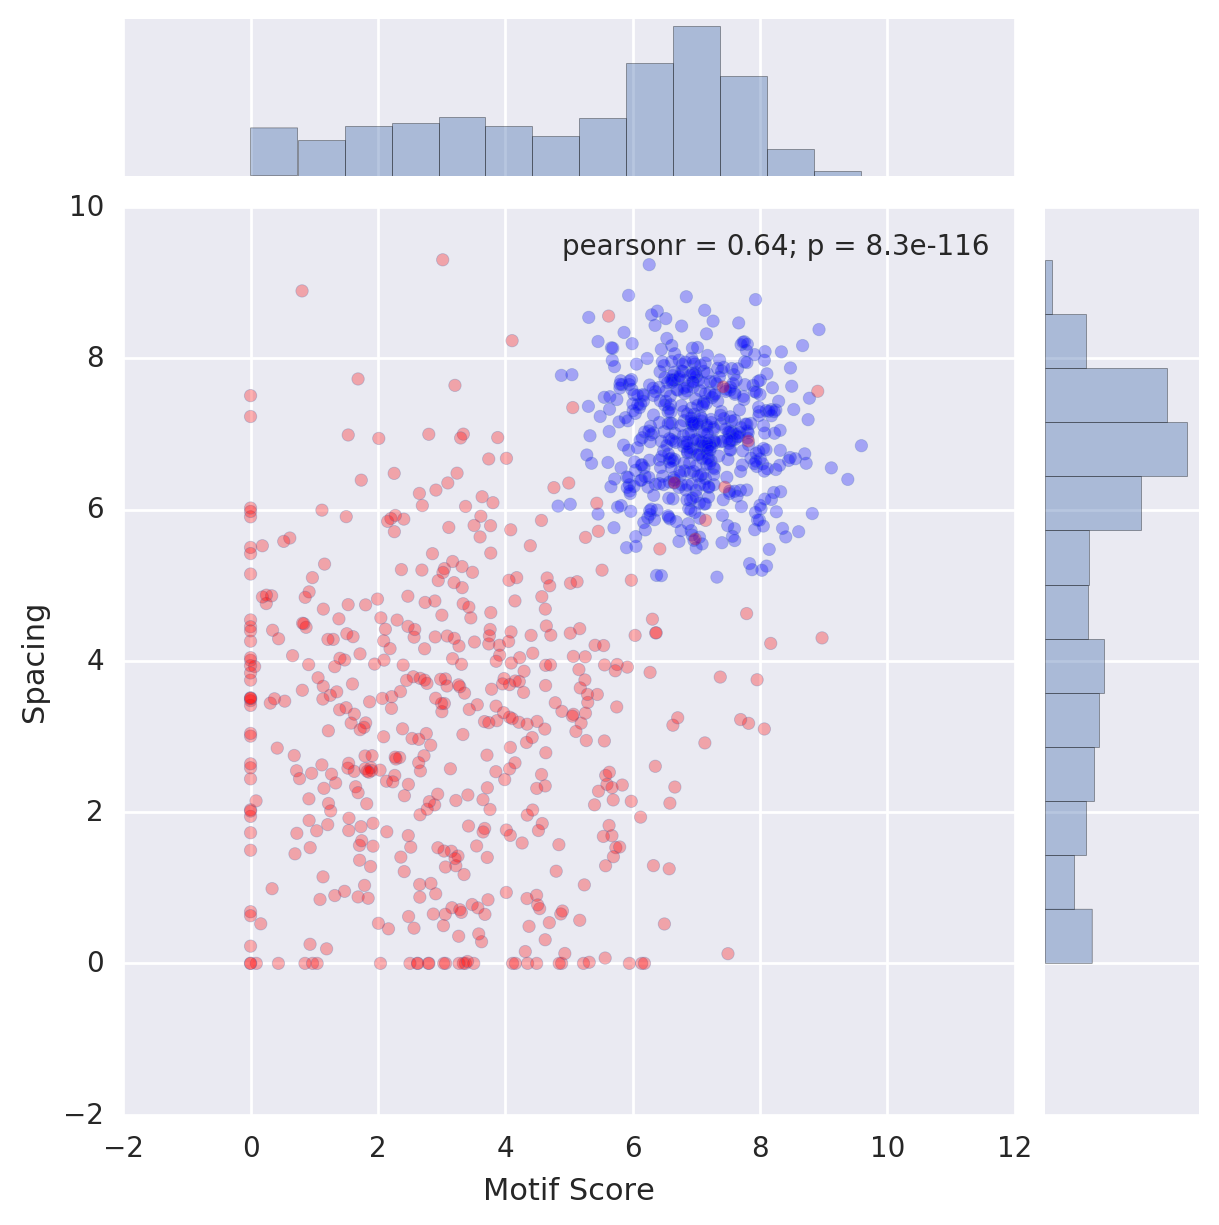

In [5]:
jg = sns.jointplot(
    x=distance_data[0], # score
    y=distance_data[1], # distance
    c= ['blue' if x == 1 else 'red' for x in distance_data[2]],
    alpha= 0.3,
)
jg.ax_joint.set_xlabel('Motif Score')
jg.ax_joint.set_ylabel('Spacing')

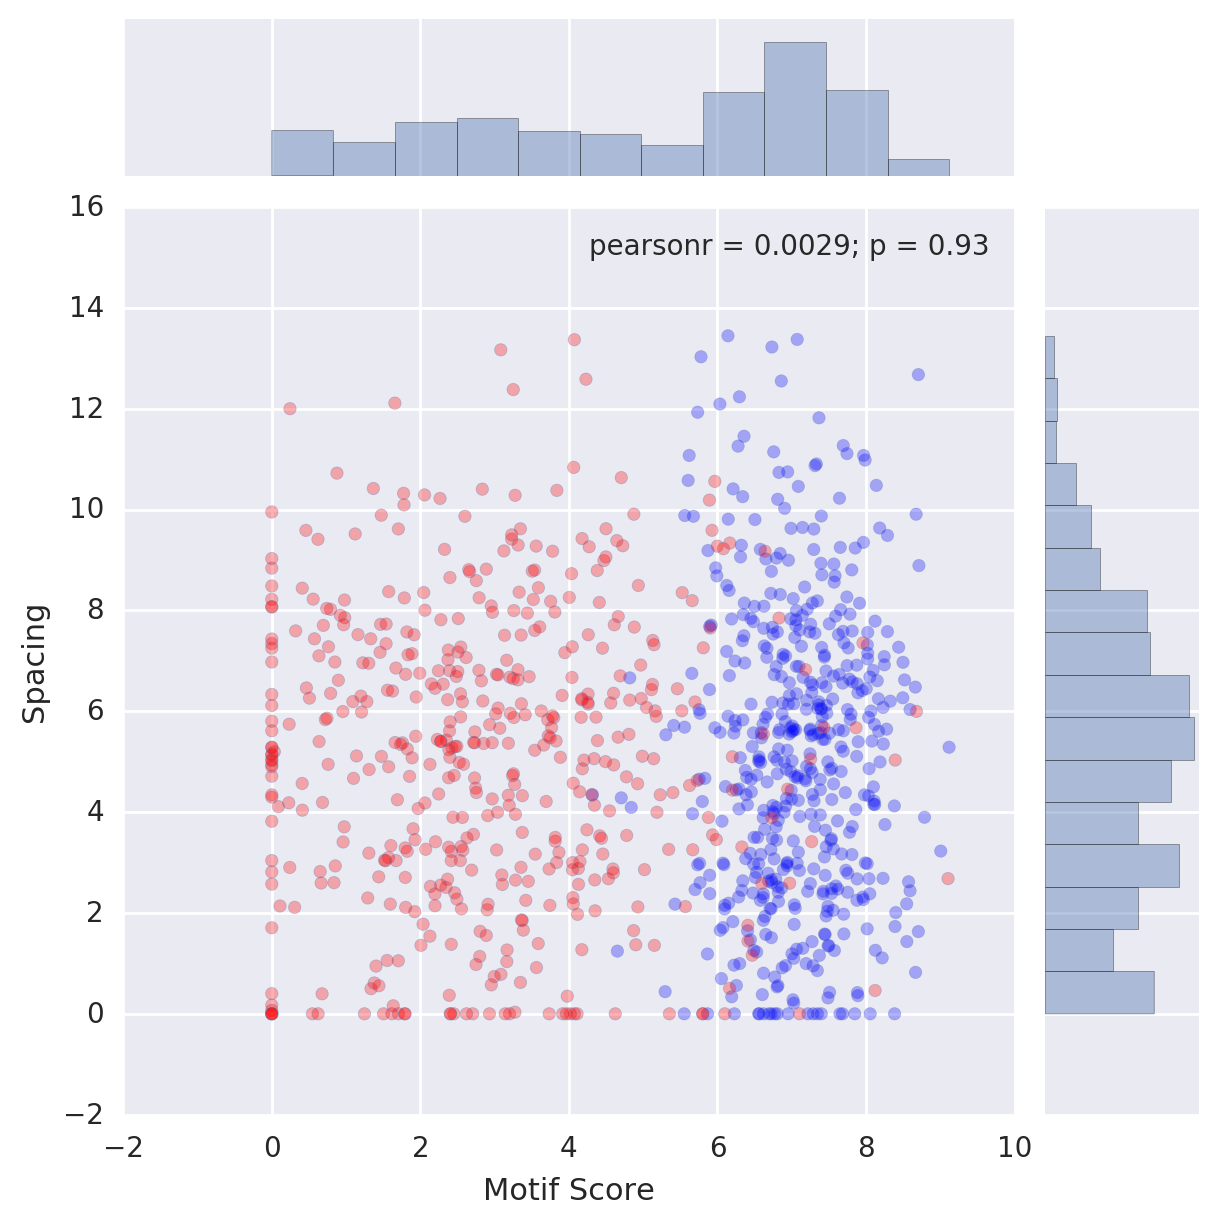

In [6]:
jg=sns.jointplot(
    x=nodistance_data[0], 
    y=nodistance_data[1],
    c= ['blue' if x == 1 else 'red' for x in nodistance_data[2]],
    alpha= 0.3,
)
jg.ax_joint.set_xlabel('Motif Score')
jg.ax_joint.set_ylabel('Spacing')

## Iris Example

### sklearn

In [7]:
# Logistic Regression
from sklearn import datasets
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

In [8]:
# load the iris datasets
dataset = datasets.load_iris()

In [9]:
filtered_dataset = [x for x in zip(dataset.data, dataset.target) if x[1] <2]
filtered_data = np.array([x[0] for x in filtered_dataset])
filtered_target = np.array([x[1] for x in filtered_dataset])

In [10]:
# fit a logistic regression model to the data
model = LogisticRegression()
model.fit(filtered_data, filtered_target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [11]:
print(model)
# make predictions
expected = filtered_target
predicted = model.predict(filtered_data)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        50
          1       1.00      1.00      1.00        50

avg / total       1.00      1.00      1.00       100

[[50  0]
 [ 0 50]]


#### Homebrew Model

#### L2 Penalized

In [12]:
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

In [13]:
#Regularized cost function
def cost_function_L2(theta, X, y, c = 0.1):
    m = len(y)
    h = sigmoid(X.dot(theta))
    tmp = np.copy(theta)
    tmp[0] = 0 
    reg = (c/(2*m)) * np.sum(tmp**2)

    return (1 / m) * (-y.T.dot(np.log(h)) - (1 - y).T.dot(np.log(1 - h))) + reg



#Regularized gradient function
def gradient_L2(theta, X, y, c = 0.1):
    m, n = X.shape
    theta = theta.reshape((n, 1))
    y = y.reshape((m, 1))
    h = sigmoid(X.dot(theta))
    tmp = np.copy(theta)
    tmp[0] = 0
    reg = c*tmp /m

    return ((1 / m) * X.T.dot(h - y)) + reg

#Optimal theta 
def logistic_regression_L2(X, y, theta, c=0.1):
    result = optimize.minimize(fun = cost_function_L2, x0 = theta, args = (X, y, c),
                         method = 'TNC', jac = gradient_L2)
    
    return result.x

#### L1 Regularization

In [14]:
#Regularized cost function
def cost_function_L1(theta, X, y, c = 0.1):
    m = len(y)
    h = sigmoid(X.dot(theta))
    tmp = np.copy(theta)
    tmp[0] = 0 
    reg = (c/m) * np.sum(abs(tmp))

    return (1 / m) * (-y.T.dot(np.log(h)) - (1 - y).T.dot(np.log(1 - h))) + reg



#Regularized gradient function
def gradient_L1(theta, X, y, c = 0.1):
    m, n = X.shape
    theta = theta.reshape((n, 1))
    y = y.reshape((m, 1))
    h = sigmoid(X.dot(theta))
    tmp = np.copy(theta)
    tmp[0] = 0
    return ((1 / m) * X.T.dot(h - y))

#Optimal theta 
def logistic_regression_L1(X, y, theta, c=0.1):
    result = optimize.minimize(fun = cost_function_L1, x0 = theta, args = (X, y, c),
                         method = 'TNC', jac = gradient_L1)
    
    return result.x

#### No regularization

In [15]:
def gradient(theta, X, y):
    m, n = X.shape
    theta = theta.reshape((n, 1))
    y = y.reshape((m, 1))
    h = sigmoid(X.dot(theta))
    return ((1 / m) * X.T.dot(h - y))

def cost_function(theta, X, y):
    m = len(y)
    h = sigmoid(X.dot(theta))
    return (1 / m) * (-y.T.dot(np.log(h)) - (1 - y).T.dot(np.log(1 - h)))
def logistic_regression_noReg(X, y, theta):
    result = optimize.minimize(fun = cost_function, x0 = theta, args = (X, y),
                         method = 'TNC', jac = gradient)
    
    return result.x

#### No Gradient

In [32]:
def logistic_regression_NM(X, y, theta):
    result = optimize.minimize(fun = cost_function, x0 = theta, args = (X, y),
                         method = 'nelder-mead',)
    
    return result.x

### With regularization

In [16]:
iris = pd.read_csv('/gpfs/data01/glasslab/home/jtao/iris.data')

In [17]:
Species = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
#Number of examples
m = iris.shape[0]
#Features
n = 4
#Number of classes
k = 3

X = np.ones((m,n + 1))
y = np.array((m,1))
X[:,1] = iris['PetalLengthCm'].values
X[:,2] = iris['PetalWidthCm'].values
X[:,3] = iris['SepalLengthCm'].values
X[:,4] = iris['SepalWidthCm'].values

#Labels
y = iris['Species'].values

#Mean normalization
for j in range(n):
    X[:, j] = (X[:, j] - X[:,j].mean())

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2, random_state = 11)

In [18]:
#Training

all_theta = np.zeros((k, n + 1))

#One vs all
i = 0
for flower in Species:
    #set the labels in 0 and 1
    tmp_y = np.array(y_train == flower, dtype = int)
    optTheta = logistic_regression_L2(X_train, tmp_y, np.zeros((n + 1,1)))
    all_theta[i] = optTheta
    i += 1

#Predictions
P = sigmoid(X_test.dot(all_theta.T)) #probability for each flower
p = [Species[np.argmax(P[i, :])] for i in range(X_test.shape[0])]
print(all_theta)
print("Test Accuracy ", metrics.accuracy_score(y_test, p) * 100 , '%')

[[ 0.         -4.39407899 -2.07949621  1.11594484 -1.66471818]
 [ 0.          2.49436247 -3.5193103  -1.86515182 -0.31160717]
 [ 0.          4.10553812  5.80419375 -1.2506833  -2.46647127]]
Test Accuracy  96.6666666667 %


### No regularization

In [19]:
Species = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
#Number of examples
m = iris.shape[0]
#Features
n = 4
#Number of classes
k = 3

X = np.ones((m,n))
y = np.array((m,1))
X[:,0] = iris['PetalLengthCm'].values
X[:,1] = iris['PetalWidthCm'].values
X[:,2] = iris['SepalLengthCm'].values
X[:,3] = iris['SepalWidthCm'].values

#Labels
y = iris['Species'].values

#Mean normalization
for j in range(n):
    X[:, j] = (X[:, j] - X[:,j].mean())

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.8, random_state = 11)

In [20]:
#Training
all_theta = np.zeros((k, n))

#One vs all
i = 0
for flower in Species:
    #set the labels in 0 and 1
    tmp_y = np.array(y_train == flower, dtype = int)
    optTheta = logistic_regression_noReg(X_train, tmp_y, np.zeros((n,1)))
    all_theta[i] = optTheta
    i += 1

#Predictions
P = sigmoid(X_test.dot(all_theta.T)) #probability for each flower
p = [Species[np.argmax(P[i, :])] for i in range(X_test.shape[0])]
print(all_theta)
print("Test Accuracy ", metrics.accuracy_score(y_test, p) * 100 , '%')

[[ -9.32999639  -8.69593714   7.69160898  26.74299239]
 [  2.16596641  -3.76919587  -1.28044622  -4.88567166]
 [ -2.0561766    7.03630078   2.44879394   6.86577391]]
Test Accuracy  79.1666666667 %


/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log


## Read in PU1 Data

In [21]:
# read in motif scores
scores_pos_frame = pd.read_csv('./PU1_mergedPeaks_C57_scaled_200_motif_scores.tsv', sep='\t', index_col=0)
scores_neg_frame = pd.read_csv('./background_motif_scores.tsv', sep='\t', index_col=0)

# read in distances to PU.1 motif
distances_pos_frame = pd.read_csv('./PU1_mergedPeaks_C57_scaled_200_motif_distances.tsv', sep='\t', index_col=0)
distances_neg_frame = pd.read_csv('./background_motif_distances.tsv', sep='\t', index_col=0)

#### Check that Indices don't overlap

In [22]:
scores_neg_frame.index.intersection(scores_pos_frame.index)

Index([], dtype='object')

In [23]:
distances_neg_frame.index.intersection(distances_pos_frame.index)

Index([], dtype='object')

### combine data frames

In [24]:
scores_frame = pd.concat([scores_pos_frame, scores_neg_frame])
distances_frame = pd.concat([distances_pos_frame, distances_neg_frame])
labels = pd.Series(data = np.array([1 for x in range(scores_pos_frame.shape[0])] + \
                                   [0 for x in range(scores_neg_frame.shape[0])]),
                   index = scores_frame.index.values)

### standardize_scores

In [25]:
from sklearn import preprocessing

In [26]:
scaler = preprocessing.StandardScaler()
standardized_scores = pd.DataFrame(scaler.fit_transform(scores_frame))
standardized_scores.columns = scores_frame.columns.values
standardized_scores.index = scores_frame.index.values
standardized_scores = standardized_scores[sorted(scores_frame.columns.values)]

In [27]:
scores_frame.shape

(101365, 192)

In [28]:
scores_train, scores_test, distances_train, distances_test, labels_train, labels_test = model_selection.train_test_split(
    standardized_scores, 
    distances_frame,
    labels,
    test_size = 0.5, 
    random_state = 12
    )

## Logistic Regression

In [38]:
optTheta = logistic_regression_NM(scores_train, 
    labels_train, 
    theta=np.zeros((scores_frame.shape[1],1)),
    )

KeyboardInterrupt: 

In [37]:
P = sigmoid(scores_test.dot(optTheta.T))

print("Test Accuracy ", metrics.accuracy_score(labels_test, [1 if x > 0.5 else 0 for x in P]) * 100 , '%')
print("Test ROC ", metrics.roc_auc_score(labels_test, P) * 100 , '%')
print("Test Precision ", metrics.precision_score(labels_test, [1 if x > 0.5 else 0 for x in P]) * 100 , '%')

Test Accuracy  85.1291360022 %
Test ROC  92.8442457302 %
Test Precision  84.7863582909 %


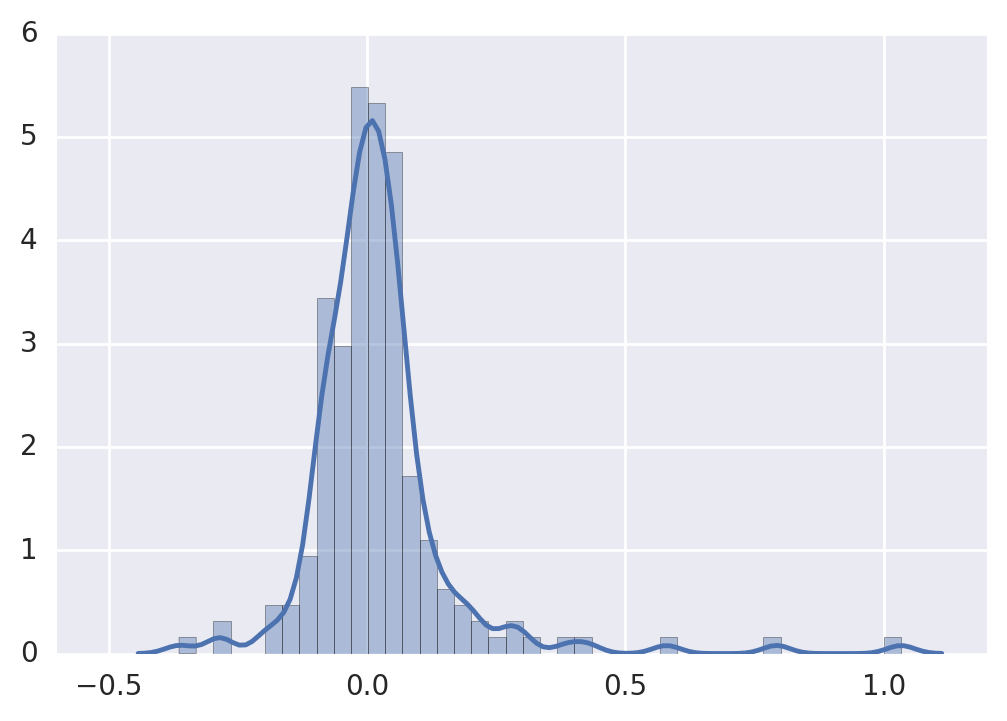

In [31]:
sns.distplot(optTheta)

## Define Distance Model

In [ ]:
def gradient(theta, X, y):
    m, n = X.shape
    theta = theta.reshape((n, 1))
    y = y.reshape((m, 1))
    h = sigmoid(X.dot(theta))
    return ((1 / m) * X.T.dot(h - y))

def cost_function(theta, X, y):
    m = len(y)
    h = sigmoid(X.dot(theta))
    return (1 / m) * (-y.T.dot(np.log(h)) - (1 - y).T.dot(np.log(1 - h)))
def logisticRegression_noReg(X, y, theta):
    result = optimize.minimize(fun = cost_function, x0 = theta, args = (X, y),
                         method = 'TNC', jac = gradient)
    
    return result.x

In [ ]:
optimize.minimize(
    loss_function, # function to optimize
    x0, # initial weights
    args=(), # initial arguments to pass in
    method='BFGS', # optimization method
    jac=None, # jacobian
    hess=None, # hessian
    bounds=None, # bounds for variables
    tol=None, # tolerance for termination
    callback=None, # called after each iteration 
)